In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-prediction-dataset-2025/loan_dataset_20000.csv
/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


In [2]:
!pip install -qq scikit-learn==1.6.1

In [3]:
import sys
import os
import itertools
import time

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import roc_auc_score

import lightgbm as lgbm

print(f"numpy version {np.__version__}")
print(f"pd version {pd.__version__}")
print(f"sklearn version {sklearn.__version__}")
print(f"lgbm version {lgbm.__version__}")

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


numpy version 2.0.2
pd version 2.2.2
sklearn version 1.6.1
lgbm version 4.6.0


In [4]:
pd.options.mode.chained_assignment = None

In [5]:
data = pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv", index_col="id")
test = pd.read_csv("/kaggle/input/playground-series-s5e11/test.csv", index_col="id")

Target = "loan_paid_back"
y = data[Target]
X = data.drop(columns=Target)

In [6]:
original_path = "/kaggle/input/loan-prediction-dataset-2025/loan_dataset_20000.csv"
original = pd.read_csv(original_path, usecols=data.columns.tolist())

y_original = original[Target]
X_original = original.drop(columns=Target)

# Feature Enginnering

In [7]:
def create_categorical_combs(X, list_of_col_tuples, delimiter="|"):
    combs = {}
    for cols in list_of_col_tuples:
        combs[delimiter.join(cols)] = X[list(cols)].astype(str).agg(delimiter.join, axis=1)
    return pd.DataFrame(combs)


def create_count_features(X, list_of_inputs):
    # list_of_inputs: list of cols or col groups
    list_of_inputs = [[col] if isinstance(col, str) else col for col in list_of_inputs]
    new_features = {}
    for cols in list_of_inputs:
        name = f"count({','.join(cols)})"
        new_features[name] = X.groupby(list(cols), dropna=False).transform('size')
    return pd.DataFrame(new_features)


def create_groupby_features_original(X, list_of_inputs, original_data):
    # list_of_inputs: list of tuples like (col_group, col, aggregation)
    # e.g. [(['col1', 'col2'], 'col3', 'mean'), (['col1', 'col2'], 'col3', 'std')]
    new_features = {}
    for cols, col, agg in list_of_inputs:
        mapping = original_data.groupby(list(cols), dropna=False)[col].agg(agg).rename(agg)
        name = f"groupby({','.join(cols)})_{agg}_{col}_original"
        new_features[name] = X[list(cols)].merge(mapping, on=cols, how='left')[agg]
    return pd.DataFrame(new_features)

In [8]:
high_cardinality = [col for col in X.columns if X[col].nunique() > 7]

In [9]:
combined = pd.concat([X, test])

In [10]:
te1 = combined[high_cardinality].astype(str).add_suffix("_te")
ce1 = create_count_features(combined, high_cardinality)

inputs = [([col], Target, "mean") for col in high_cardinality]
te1_original = create_groupby_features_original(combined, inputs, original)

In [11]:
te1['annual_income_te'] = (te1['annual_income_te'].astype(float).round() // 2).astype(str)
te1['loan_amount_te'] = (te1['loan_amount_te'].astype(float).round() // 2).astype(str)

# quantile binning
loan_amount_quantiled = pd.qcut(combined["loan_amount"], q=10_000, duplicates='drop',).to_frame().add_suffix("_quantiled_te")
annual_income_quantiled = pd.qcut(combined["annual_income"], q=10_000, duplicates='drop',).to_frame().add_suffix("_quantiled_te")

# uniform binning
loan_amount_binned = pd.cut(combined["loan_amount"], bins=10_000,).to_frame().add_suffix("_binned_te")
annual_income_binned = pd.cut(combined["annual_income"], bins=10_000,).to_frame().add_suffix("_binned_te")

# apply log before binning
annual_income_log_binned = pd.cut(np.log1p(combined["annual_income"]), bins=10_000, duplicates='drop').to_frame().add_suffix("_log_binned_te")
loan_amount_log_binned = pd.cut(np.log1p(combined["loan_amount"]), bins=8_000, duplicates='drop').to_frame().add_suffix("_log_binned_te")

# convert to int
annual_income_int = combined["annual_income"].astype(int).to_frame().add_suffix("_int_te")
loan_amount_int = combined["loan_amount"].astype(int).to_frame().add_suffix("_int_te")

In [12]:
digits = {}

for col in combined.select_dtypes(["float"]).columns:

    splitted = combined[col].astype(str).str.split(".", expand=True)
    non_decimal_part = splitted[0]
    decimal_part = splitted[1]

    max_len_non_decimal = non_decimal_part.str.len().max()
    max_len_decimal = decimal_part.str.len().max()

    non_decimal_part_padded = non_decimal_part.str.rjust(max_len_non_decimal, '0')
    decimal_part_padded = decimal_part.str.ljust(max_len_decimal, '0')

    for i in range(max_len_non_decimal):
        digits[f"{col}_digit{i}"] = non_decimal_part_padded.str[i].astype(int)

    for i in range(max_len_decimal):
        digits[f"{col}_decimal_digit{i}"] = decimal_part_padded.str[i].astype(int)

digits["credit_score_digit0"] = combined["credit_score"] % 10
digits["credit_score_digit1"] = (combined["credit_score"] // 10) % 10
digits["credit_score_digit2"] = combined["credit_score"] // 100

digits = pd.DataFrame(digits, index=combined.index)

In [13]:
# extract combinations of digits

cols = [col for col in digits.columns if "interest_rate" in col]
digits_combs = create_categorical_combs(digits, itertools.combinations(cols, 2)).add_suffix("_te")

In [14]:
# ratio of counts in train data over counts in original data

inputs = [([col], Target, "size") for col in high_cardinality]
ce1_original = create_groupby_features_original(combined, inputs, original)
count_ratios = {}
for col_index in range(len(ce1.columns)):
    name = f"{ce1.columns[col_index]}_ratio"
    count_ratios[name] = ce1.iloc[:, col_index] / ce1_original.iloc[:, col_index]
count_ratios = pd.DataFrame(count_ratios)

In [15]:
combined = pd.concat([combined,
                      te1,
                      ce1,
                      te1_original,
                      loan_amount_quantiled,
                      annual_income_quantiled,
                      loan_amount_binned,
                      annual_income_binned,
                      annual_income_log_binned,
                      loan_amount_log_binned,
                      annual_income_int,
                      loan_amount_int,
                      digits,
                      digits_combs,
                      count_ratios,
                      ], axis=1)

cat = combined.select_dtypes("object").columns.tolist()
combined[cat] = combined[cat].astype("category")

to_drop = ["grade_subgrade"]
combined = combined.drop(columns=to_drop)


X, test = combined.loc[X.index], combined.loc[test.index]

# Training

In [16]:
params = dict(
    objective="binary",
    metric="auc",
    n_estimators=7_500,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.5,
    colsample_bytree=0.2,
    lambda_l2=15.0,
    lambda_l1=10.0,
    random_state=42,
    verbosity=-1,
)

In [17]:
metric_func = roc_auc_score

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X))
test_preds = np.zeros((len(test), num_folds))

scores = []
models = []

time0 = time.perf_counter()


for fold_number, (train_indices, val_indices) in enumerate(kfold.split(X, y)):

    print(f"fold {fold_number}")

    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    X_val = X.iloc[val_indices]
    y_val = y.iloc[val_indices]
    X_test = test.copy()

    to_target_encode = [col for col in X_train.columns if col.endswith("_te")]
    print(f"target encoding {len(to_target_encode)} columns")
    if len(to_target_encode) > 0:
        encoder = TargetEncoder(cv=5, shuffle=True, random_state=42, smooth=10.0).set_output(transform="pandas")
        X_train[to_target_encode] = encoder.fit_transform(X_train[to_target_encode], y_train)
        X_val[to_target_encode] = encoder.transform(X_val[to_target_encode])
        X_test[to_target_encode] = encoder.transform(X_test[to_target_encode])


    model = lgbm.LGBMClassifier(**params)
    models.append(model)

    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              callbacks=[lgbm.log_evaluation(1000),
                          # lgbm.early_stopping(stopping_rounds=200),
                          ],
              )

    val_preds = model.predict_proba(X_val)[:, 1]
    oof_preds[val_indices] = val_preds

    cur_test_preds = model.predict_proba(X_test)[:, 1]
    test_preds[:, fold_number] = cur_test_preds

    score = metric_func(y_val, val_preds)
    print(score)
    scores.append(float(score))


time1 = time.perf_counter()

print(f"time {round(time1 - time0, 2)}s")
print(f"scores {scores}")
print(f"cv mean {np.mean(scores)}")
print(f"cv std {np.std(scores)}")
print(f"oof cv {metric_func(y, oof_preds)}")

fold 0
target encoding 25 columns
[1000]	valid_0's auc: 0.926988
[2000]	valid_0's auc: 0.928218
[3000]	valid_0's auc: 0.928471
[4000]	valid_0's auc: 0.928566
[5000]	valid_0's auc: 0.92864
[6000]	valid_0's auc: 0.928684
[7000]	valid_0's auc: 0.928692
0.9286882755276302
fold 1
target encoding 25 columns
[1000]	valid_0's auc: 0.927204
[2000]	valid_0's auc: 0.928461
[3000]	valid_0's auc: 0.928808
[4000]	valid_0's auc: 0.92895
[5000]	valid_0's auc: 0.929026
[6000]	valid_0's auc: 0.929068
[7000]	valid_0's auc: 0.929073
0.9290810466888806
fold 2
target encoding 25 columns
[1000]	valid_0's auc: 0.926424
[2000]	valid_0's auc: 0.927657
[3000]	valid_0's auc: 0.927928
[4000]	valid_0's auc: 0.928061
[5000]	valid_0's auc: 0.928134
[6000]	valid_0's auc: 0.928144
[7000]	valid_0's auc: 0.928146
0.9281416267853719
fold 3
target encoding 25 columns
[1000]	valid_0's auc: 0.924131
[2000]	valid_0's auc: 0.925453
[3000]	valid_0's auc: 0.925771
[4000]	valid_0's auc: 0.925907
[5000]	valid_0's auc: 0.926002
[60

# Submission

In [18]:
final_preds = test_preds.mean(axis=1)
preds_df = pd.DataFrame(final_preds, index=test.index, columns=[Target])

array([[<Axes: title={'center': 'loan_paid_back'}>]], dtype=object)

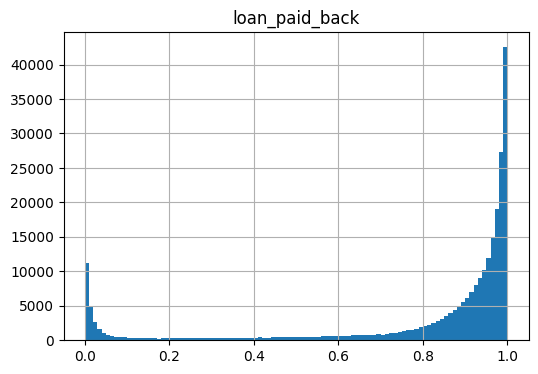

In [19]:
preds_df.hist(bins=100, figsize=(6, 4))

In [20]:
preds_df.to_csv("submission.csv")